In [51]:
from validator.InstanceCO22 import InstanceCO22
import warnings
from collections import OrderedDict
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
from util import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from vrpy import VehicleRoutingProblem
import pprint
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.CRITICAL)
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
instance = loadInstance(30)

In [53]:
instance.Products

[    1     4,     2     7,     3    10]

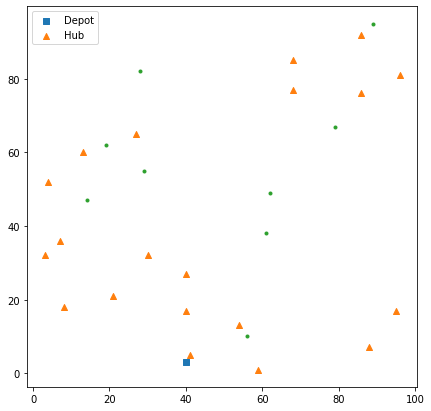

In [54]:
plotInstance(instance)

In [55]:
def locIDtoHubID(loc_ID):
    return loc_ID - 1

def hubIDtoLocID(hub_ID):
    return hub_ID + 1

In [56]:
def distance(loc1: InstanceCO22.Location, loc2: InstanceCO22.Location, ceil: bool = True) -> float:
    dist =  math.sqrt((loc1.X - loc2.X)**2 + (loc1.Y - loc2.Y)**2)
    if ceil:
        return math.ceil(dist)
    else:
        return dist

In [57]:
def requestClosestHub(instance: InstanceCO22, request: InstanceCO22.Request) -> int:
    nHubs = len(instance.Hubs)
    hubs = instance.Locations[1:nHubs+1]
    minDist = math.inf
    minDistHubLocID = None
    for i, hub in enumerate(hubs):
        if request.ID in instance.Hubs[i].allowedRequests:
            hubDist = distance(instance.Locations[request.customerLocID-1],hub)
            if hubDist < minDist:
                minDist = hubDist
                minDistHubLocID = hub.ID
    return minDistHubLocID

In [58]:
def requestsClosestHub(instance: InstanceCO22) -> dict:
    #return dictionary of {'LOC_ID': ' NEAREST LOC_ID'}
    res = {}
    for req in instance.Requests:
        res[req.ID] = requestClosestHub(instance, req)
    return res

In [59]:
def requestsPerHub(instance: InstanceCO22) -> dict:
    closestHubPerRequest = requestsClosestHub(instance= instance)
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    res = {val: [] for val in hubLocIDs}
    for hubLocID in hubLocIDs:
        for reqID, closestHubLocID in closestHubPerRequest.items():
            if closestHubLocID is hubLocID:
                res[hubLocID].append(reqID)
    return res

In [60]:
def amountPerProduct(instance: InstanceCO22, requests: list) -> list:
    nProducts = len(instance.Products)
    res = [None]*nProducts
    for i in range(nProducts):
        res[i] = sum([req.amounts[i] for req in requests])
    return res

In [61]:
def filterRequests(instance: InstanceCO22, day: int = None, locationsID: int = None) -> list:
    res = instance.Requests.copy()
    if day != None:
        res = [_ for _ in res if _.desiredDay is day]
    if locationsID != None:
        res = [_ for _ in res if _.customerLocID in locationsID]
    return res

In [62]:
def addAllEdges(G: nx.DiGraph, checkWindowOverlap: bool = False) -> nx.DiGraph:
    for locID1, node1 in G.nodes(data=True):
        for locID2, node2 in G.nodes(data=True):
            if locID1 != locID2:
                if checkWindowOverlap and locID1 not in ["Source","Sink"] and locID2 not in ["Source", "Sink"] and not windowOverlap(node1['periodIDs'], node2['periodIDs']):
                        continue
                dist = math.ceil( math.sqrt( pow(node1['X']-node2['X'],2) + pow(node1['Y']-node2['Y'],2) ))
                if locID1 == "Sink" or locID2 == "Source" or (locID1 == "Source" and locID2 == "Sink"):
                    continue
                else:
                    G.add_edge(locID1, locID2, time = dist, cost=dist)   
    return G        

In [63]:
def createNxHub(instance: InstanceCO22, hubLocID: int, requests: list) -> nx.DiGraph:
    G = nx.DiGraph()
    for req in requests:
        reqLoc = instance.Locations[req.customerLocID-1]
        G.add_node(req.ID, locID = reqLoc.ID, reqID = req.ID, X=reqLoc.X, Y=reqLoc.Y, demand = sum(req.amounts), amounts = req.amounts)
    hubLoc = instance.Locations[hubLocID]
    G.add_node("Source", locID = hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G.add_node("Sink",locID = hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G = addAllEdges(G)
    return G

In [64]:
def solveHubVRP(instance: InstanceCO22, hubLocID: int, requests: list) -> dict:
    #create networkX
    G = createNxHub(instance, hubLocID, requests)
    G_dict = {i:v for i,v in G.nodes(data=True)}
    #print(G_dict.keys())
    prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
    prob.duration = instance.VanMaxDistance
    prob.fixed_cost = instance.VanDayCost
    prob.solve()
    best_routes = prob.best_routes
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res =  {
        'routes': {key: {'route': [G_dict[id] for id in best_routes[key]]} for key in best_routes.keys()},
        'demand': sum([sum(req.amounts) for req in requests]),
        'amounts': amountPerProduct(instance, requests)
    }
    return res

In [65]:
def createNxDepot(instance: InstanceCO22, dayRoutes: dict) -> nx.DiGraph:
    G = nx.DiGraph()
    #add hubs
    for (day, hubLocID), hubData in dayRoutes.items():
        G.add_node(f"{hubLocID}.1", locID = hubLocID, demand = 0, amounts= 0, X=instance.Locations[hubLocID].X, Y=instance.Locations[hubLocID].Y)

    for (day, hubLocID), hubData in dayRoutes.items():
        i = 1
        nodeID = f"{hubLocID}.{i}"
        while nodeID in G.nodes and G.nodes[nodeID]['demand'] + hubData['demand'] > instance.TruckCapacity: 
            i+=1
            nodeID = f"{hubLocID}.{i}"
        if nodeID not in G.nodes:
            G.add_node(nodeID, locID = hubLocID, demand = 0, amounts= 0, X=instance.Locations[hubLocID].X, Y=instance.Locations[hubLocID].Y)

        G.nodes[nodeID]['amounts'] = list(np.array(G.nodes[nodeID]['amounts']) + np.array(hubData['amounts']))
        G.nodes[nodeID]['demand'] = G.nodes[nodeID]['demand']+hubData['demand']

    G.add_node("Source", locID=1, X = instance.Locations[0].X, Y = instance.Locations[0].Y)
    G.add_node("Sink", locID=1, X = instance.Locations[0].X, Y = instance.Locations[0].Y)

    G = addAllEdges(G)
    return G

In [66]:
def solveDepotVRP(instance: InstanceCO22, dayRoutes: dict) -> dict:
    #for solving per day
    G = createNxDepot(instance, dayRoutes)
    G_dict = {i:v for i,v in G.nodes(data=True)}
    print(G_dict.keys())

    prob = VehicleRoutingProblem(G, load_capacity=instance.TruckCapacity)
    prob.duration = instance.TruckMaxDistance
    prob.fixed_cost = instance.TruckDayCost
    prob.solve()
    best_routes = prob.best_routes
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res =  {key: [G_dict[id] for id in best_routes[key]] for key in best_routes.keys()}
    return res

In [67]:
def solveHub(instance: InstanceCO22) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    hubClusters = requestsPerHub(instance)
    hubRoutes = {}  
    for day in range(1, nDays+1):                                                   #hub routing
        dayRoutes = {}
        for hubLocID in hubLocIDs:
            hubCluster = hubClusters[hubLocID]
            #requestsToServe = filterRequests(instance, day, hubCluster)
            requestsToServe =[_ for _ in instance.Requests if _.ID in hubCluster and _.desiredDay is day]
            print(hubCluster, [_.ID for _ in requestsToServe])   #
            if(len(requestsToServe) > 0):
                dayHubRoutes = solveHubVRP(instance, hubLocID, requestsToServe)
                dayRoutes[hubLocID] = dayHubRoutes
        hubRoutes[day] = dayRoutes
    return hubRoutes

In [68]:
def extractDays(hubRoutes, days: list) -> dict:
    res = {}
    for day, dayRoutes in hubRoutes.items():
        if day in days:
            for hubLocID in dayRoutes:
                newID = (day, hubLocID)
                res[newID] = dayRoutes[hubLocID]
    return res

In [69]:
min([_.daysFresh for _ in instance.Products])

4

In [70]:
%%capture
dayRoutes = solveHub(instance)
dayRoutes = extractDays(dayRoutes, [1,2,3,4])
G = createNxDepot(instance,dayRoutes)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 534 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 534.0
INFO:vrpy.master_solve_pulp:total cost = 534.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 524 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 524 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 524.0
INFO:vrpy.master_solve_pulp:total cost = 524.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 464 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 464 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 464.0
INFO:vrpy.master_solve_pulp:total cost = 464.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 461 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 461 and 1 vehic

In [71]:
G.nodes(data=True)

NodeDataView({'5.1': {'locID': 5, 'demand': 25, 'amounts': [5, 16, 4], 'X': 68, 'Y': 85}, '9.1': {'locID': 9, 'demand': 3, 'amounts': [0, 2, 1], 'X': 68, 'Y': 77}, '14.1': {'locID': 14, 'demand': 8, 'amounts': [5, 3, 0], 'X': 40, 'Y': 27}, '18.1': {'locID': 18, 'demand': 37, 'amounts': [8, 11, 18], 'X': 86, 'Y': 92}, '20.1': {'locID': 20, 'demand': 16, 'amounts': [0, 9, 7], 'X': 8, 'Y': 18}, '3.1': {'locID': 3, 'demand': 11, 'amounts': [5, 0, 6], 'X': 96, 'Y': 81}, '4.1': {'locID': 4, 'demand': 13, 'amounts': [6, 7, 0], 'X': 4, 'Y': 52}, '7.1': {'locID': 7, 'demand': 11, 'amounts': [0, 7, 4], 'X': 95, 'Y': 17}, '17.1': {'locID': 17, 'demand': 8, 'amounts': [0, 0, 8], 'X': 27, 'Y': 65}, '19.1': {'locID': 19, 'demand': 7, 'amounts': [0, 1, 6], 'X': 21, 'Y': 21}, 'Source': {'locID': 1, 'X': 40, 'Y': 3}, 'Sink': {'locID': 1, 'X': 40, 'Y': 3}})

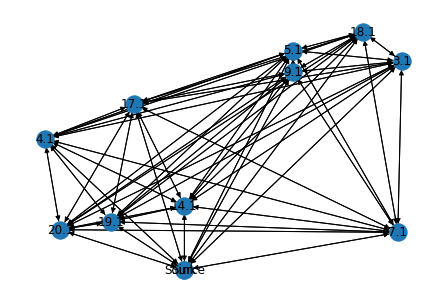

In [72]:
pos = {id: (val['X'],val['Y']) for id,val in G.nodes(data=True)}
nx.draw(G,pos=pos, with_labels=True)

In [41]:
prob = VehicleRoutingProblem(G, load_capacity=instance.TruckCapacity)
prob.duration = instance.TruckMaxDistance
prob.fixed_cost = instance.TruckDayCost
prob.solve()

INFO:vrpy.vrp:new upper bound : max num stops = 12
INFO:vrpy.vrp:Clarke & Wright solution found with value 2328 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2328 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2328.0
INFO:vrpy.vrp:iteration 1, 2328.0
INFO:vrpy.vrp:iteration 2, 2328.0
INFO:vrpy.vrp:iteration 3, 2328.0
INFO:vrpy.vrp:iteration 4, 2328.0
INFO:vrpy.vrp:iteration 5, 2328.0
INFO:vrpy.vrp:iteration 6, 2328.0
INFO:vrpy.vrp:iteration 7, 2328.0
INFO:vrpy.vrp:iteration 8, 2328.0
INFO:vrpy.vrp:iteration 9, 2328.0
INFO:vrpy.vrp:iteration 10, 2328.0
INFO:vrpy.vrp:iteration 11, 2328.0
INFO:vrpy.vrp:iteration 12, 2328.0
INFO:vrpy.vrp:iteration 13, 2328.0
INFO:vrpy.vrp:iteration 14, 2328.0
INFO:vrpy.vrp:iteration 15, 2328.0
INFO:vrpy.vrp:iteration 16, 2328.0
INFO:vrpy.vrp:iteration 17, 2328.0
INFO:vrpy.vrp:iteration 18, 2328.0
INFO:vrpy.vrp:iteration 19, 2328.0
INFO:vrpy.vrp:iteration 20, 2328.0
INFO:vrpy.vrp:iteration 21, 2328.0
INFO:vrpy.vrp:iteration 22, 2328.0
INFO:vrpy.v

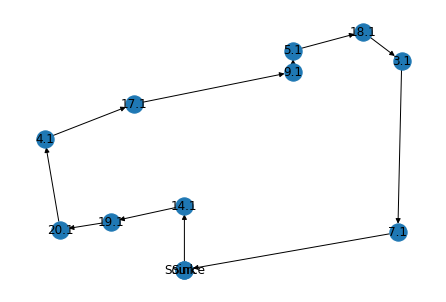

In [50]:
nx.draw(prob._best_routes_as_graphs[0], pos=pos, with_labels=True)

In [19]:
class timeWindowGenerator(object):
    def __init__(self, day_length=1000, padding=200, n=20):
        res = []
        for i in range(0,n):
            begin = day_length*i + padding*i
            window = [begin, begin+day_length ]
            res.append(window)
        self.windows = res

    def getWindow(self, d1, d2):
        return [self.windows[d1-1][0], self.windows[d2-1][1]], list(range(d1,d2+1))

In [20]:
def windowOverlap(w1, w2):
    return bool(set(w1) & set(w2))

In [21]:
def giantDepotNx(hubRoute: dict) -> nx.DiGraph:
    G = nx.DiGraph()
    twg = timeWindowGenerator(1000,200,20)
    daysFresh = [_.daysFresh for _ in instance.Products]
    productIDs = list(range(1, len(instance.Products)+1))
    for day, dayRoute in hubRoute.items():  # for every day
        for hubLocID, hubData in dayRoute.items():  # for every hub
            for productID in productIDs:
                productDemand = hubData['amounts'][productID-1]
                if productDemand > 0:
                    d1 = max(day - daysFresh[productID-1]+1, 1)
                    window, periodIDs = twg.getWindow(d1=d1, d2=day)
                    upper = window[1]
                    lower = window[0]
                    nodeID = f"d{day}h{hubLocID}p{productID}"
                    G.add_node(
                        nodeID,
                        X=instance.Locations[hubLocID].X,
                        Y=instance.Locations[hubLocID].Y,
                        upper=upper,
                        lower=lower,
                        day=day,
                        periodIDs = periodIDs,
                        productID=productID,
                        hubLocID=hubLocID,
                        demand=productDemand)

    G.add_node("Source", X=instance.Locations[0].X, Y=instance.Locations[0].Y)
    G.add_node("Sink", X=instance.Locations[0].X, Y=instance.Locations[0].Y)
    G = addAllEdges(G, checkWindowOverlap=True)
    return G

In [22]:
%%capture
res = solveHub(instance)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 308 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 308 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 308.0
INFO:vrpy.master_solve_pulp:total cost = 308.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 194 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 194 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 194.0
INFO:vrpy.master_solve_pulp:total cost = 194.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 208 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 208 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 208.0
INFO:vrpy.master_solve_pulp:total cost = 208.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 302 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 302 and 1 vehic

In [24]:
extractDays(res,[1,2,3,4]).keys()

dict_keys([(1, 2), (1, 3), (2, 2), (2, 3), (3, 2), (4, 2), (4, 3)])

In [86]:
def solve(instance: InstanceCO22) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    hubClusters = requestsPerHub(instance)
    hubRoutes = {}  
    for day in range(1, nDays+1):                                                   #hub routing
        dayRoutes = {}
        for hubLocID in hubLocIDs:
            hubCluster = hubClusters[hubLocID]
            #requestsToServe = filterRequests(instance, day, hubCluster)
            requestsToServe =[_ for _ in instance.Requests if _.ID in hubCluster and _.desiredDay is day]
            print(hubCluster, [_.ID for _ in requestsToServe])   #
            if(len(requestsToServe) > 0):
                dayHubRoutes = solveHubVRP(instance, hubLocID, requestsToServe)
                dayRoutes[hubLocID] = dayHubRoutes
        hubRoutes[day] = dayRoutes
    depotRoutes = {}
    dmin = min([_.daysFresh for _ in instance.Products])
     
    for i in range(0, math.ceil(nDays/dmin)):  
        periodBegin = dmin*i+1
        periodEnd = dmin*(i+1)+1
        print(i, periodBegin, periodEnd)
        period = list(range(periodBegin, periodEnd))
        periodRoutes = extractDays(hubRoutes, period)
        if len(hubRoutes[day])>0:                                                #depot routing
            res = solveDepotVRP(instance, periodRoutes)
            depotRoutes[periodBegin] = res
        else:
            depotRoutes[periodBegin] = {}
    return {'hubRoutes': hubRoutes, 'depotRoutes': depotRoutes}

In [87]:
%%capture
res = solve(instance)

INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 162 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 162 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 162.0
INFO:vrpy.master_solve_pulp:total cost = 162.0
INFO:vrpy.vrp:new upper bound : max num stops = 9
INFO:vrpy.vrp:Clarke & Wright solution found with value 406 and 2 vehicles
INFO:vrpy.vrp:Greedy solution found with value 434 and 2 vehicles
INFO:vrpy.vrp:iteration 0, 406.0
INFO:vrpy.vrp:iteration 1, 406.0
INFO:vrpy.vrp:iteration 2, 406.0
INFO:vrpy.vrp:iteration 3, 406.0
INFO:vrpy.vrp:iteration 4, 406.0
INFO:vrpy.vrp:iteration 5, 406.0
INFO:vrpy.vrp:iteration 6, 397.79
INFO:vrpy.vrp:iteration 7, 395.18
INFO:vrpy.vrp:iteration 8, 391.62
INFO:vrpy.vrp:iteration 9, 382.5
INFO:vrpy.vrp:iteration 10, 380.37
INFO:vrpy.vrp:iteration 11, 377.40
INFO:vrpy.vrp:iteration 12, 374.71
INFO:vrpy.vrp:iteration 13, 374.71
INFO:vrpy.vrp:iteration 14, 364.33
INFO:vrpy.vrp:iteration 15, 36

In [88]:
print(pprint.pformat(res))

{'depotRoutes': {1: {1: [{'X': 63,
                          'Y': 92,
                          'collect': 0,
                          'demand': 0,
                          'frequency': 1,
                          'locID': 1,
                          'lower': 0,
                          'service_time': 0,
                          'upper': 0},
                         {'X': 39,
                          'Y': 64,
                          'amounts': [115],
                          'collect': 0,
                          'demand': 115,
                          'frequency': 1,
                          'locID': 3,
                          'lower': 0,
                          'service_time': 0,
                          'upper': 0},
                         {'X': 63,
                          'Y': 92,
                          'collect': 0,
                          'demand': 0,
                          'frequency': 1,
                          'locID': 1,
                       

In [89]:
def solutionToStr(instance: InstanceCO22, res: dict):
    resultString = "DATASET = CO2022_11 \n \n"

    for day in range(1, instance.Days+1):
        resultString += f"DAY = {day} \n"

        truckString = ""
        if day in res['depotRoutes'].keys():
            nTrucks = len(res['depotRoutes'][day])
            for routeID, truckRoute in res['depotRoutes'][day].items():
                truckString += f"{routeID} "
                for i, hubData in enumerate(truckRoute[1:-1]):
                    amountPerProduct = hubData['amounts']
                    truckString += f"H{hubData['locID'] - 1} {','.join([str(_) for _ in amountPerProduct])} "
                truckString += "\n"
        else:
            nTrucks = 0
            
        resultString += f"NUMBER_OF_TRUCKS = {nTrucks} \n"
        resultString += truckString

        nVans = 0
        i = 0
        vanString = ""
        for hubLocID in res['hubRoutes'][day].keys():
            for _, route in res['hubRoutes'][day][hubLocID]['routes'].items():
                i+=1
                reqIds = [_['reqID'] for _ in route['route'][1:-1] ]
                vanString += f"{i} H{hubLocID-1} {' '.join([str(_) for _ in reqIds])} \n"
            nVans += len(res['hubRoutes'][day][hubLocID]['routes'])
        resultString += f"NUMBER_OF_VANS = {nVans} \n"  
        resultString += vanString + "\n"
    return resultString
    

In [90]:
solutionToStr(instance,res)

'DATASET = CO2022_11 \n \nDAY = 1 \nNUMBER_OF_TRUCKS = 6 \n1 H2 115 \n2 H1 92 \n3 H2 87 \n4 H2 34 \n5 H2 94 \n6 H2 104 \nNUMBER_OF_VANS = 3 \n1 H1 2 5 \n2 H2 1 9 \n3 H2 11 7 8 10 6 3 4 \n\nDAY = 2 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 1 \n1 H2 16 14 12 13 15 \n\nDAY = 3 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 2 \n1 H1 21 \n2 H2 20 17 18 19 \n\nDAY = 4 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 4 \n1 H1 28 31 33 37 \n2 H2 29 34 \n3 H2 25 27 26 38 39 \n4 H2 23 22 24 36 32 30 35 \n\nDAY = 5 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 3 \n1 H1 40 45 44 49 \n2 H2 47 42 41 46 50 \n3 H2 43 48 \n\nDAY = 6 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 3 \n1 H1 57 \n2 H2 52 51 55 54 59 \n3 H2 56 53 58 \n\nDAY = 7 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 3 \n1 H1 62 \n2 H2 66 67 68 \n3 H2 61 69 63 64 60 65 \n\nDAY = 8 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 3 \n1 H1 70 \n2 H2 76 71 77 \n3 H2 72 74 73 75 \n\nDAY = 9 \nNUMBER_OF_TRUCKS = 0 \nNUMBER_OF_VANS = 3 \n1 H1 80 \n2 H2 84 79 82 83 88 \n3 

In [91]:
solutionStr = solutionToStr(instance,res)
with open("./solution_test_greedy2.txt" ,'w') as file:
    file.write(solutionStr)


In [ ]:
#assign hub to locations
#for each day, for each hub:
    #get request for hub, day
    #turn into networkX graph
    #solve using vrpy
    #store results
